In [1]:
import sys

sys.path.append("../")

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands
from math import sqrt
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

# DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'
DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/vn30'

In [11]:
symbols = ['VN30F1M', 'HPG', 'STB', 'TCB', 'POW', 'SSI', 'CTG', 'MBB', 'VPB', 'VRE',
       'VHM', 'HDB', 'PDR', 'PLX', 'FPT', 'KDH', 'VNM',
       'BID', 'NVL', 'MSN', 'BVH', 'TPB', 'GAS', 'MWG', 'VIC', 'PNJ',
       'VJC', 'VCB']

agg_dict = {'open': 'first',
          'high': 'max',
          'low': 'min',
          'close': 'last',
          'volume': 'mean'}

data = []
start_date = '2015-01-01'
test_end = '2020-01-01'
end_date = '2021-06-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}_1h.csv'
        df = pd.read_csv(file, 
                        parse_dates=['datetime'], 
                        index_col=['datetime'])
        # df = df[df.index < end_date].copy()
        df = df[~df.index.duplicated(keep='first')]
        df = df.resample('1h').agg(agg_dict)

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        print(symbol)

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,VN30F1M,HPG,STB,TCB,POW,SSI,CTG,MBB,VPB,VRE,...,NVL,MSN,BVH,TPB,GAS,MWG,VIC,PNJ,VJC,VCB
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-02 02:00:00,6.889388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 03:00:00,6.892337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 04:00:00,6.893656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 06:00:00,6.897402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[(df.index <= test_end)][symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    print("trace_crit_value",trace_crit_value)
    print("eigen_crit_value",eigen_crit_value)
    print("lr1",result.lr1)
    print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        return coint_pair



In [18]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))
pairs = [p for p in pairs if 'VN30F1M' in list(p)]
print(f'Scanning {len(pairs)}')

def scan_pair(pair):
    try:
        pair = list(pair)
        return test_johansen(list(pair))
    except Exception:
        pass

    
cointegrating_pairs = Parallel(n_jobs=10)(delayed(scan_pair)(pair) for pair in pairs)
# cointegrating_pairs
cointegrating_pairs = [pair for pair in cointegrating_pairs if pair is not None]
coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

Scanning 27
trace_crit_value [13.4294  2.7055]
eigen_crit_value [12.2971  2.7055]
lr1 [9.25251679 1.50645108]
lr2 [7.74606571 1.50645108]
trace_crit_value [13.4294  2.7055]
eigen_crit_value [12.2971  2.7055]
lr1 [7.31238074 0.88663777]
lr2 [6.42574297 0.88663777]
trace_crit_value [13.4294  2.7055]
eigen_crit_value [12.2971  2.7055]
lr1 [9.24880446 1.93777659]
lr2 [7.31102787 1.93777659]
trace_crit_value [13.4294  2.7055]
eigen_crit_value [12.2971  2.7055]
lr1 [8.34042088 0.20341509]
lr2 [8.13700578 0.20341509]
trace_crit_value [13.4294  2.7055]
eigen_crit_value [12.2971  2.7055]
lr1 [7.80162599 0.24613762]
lr2 [7.55548837 0.24613762]
trace_crit_value [13.4294  2.7055]
eigen_crit_value [12.2971  2.7055]
lr1 [16.97517303  6.73524627]
lr2 [10.23992677  6.73524627]
trace_crit_value [13.4294  2.7055]
eigen_crit_value [12.2971  2.7055]
lr1 [16.63124513  6.23398644]
lr2 [10.39725869  6.23398644]
trace_crit_value [13.4294  2.7055]
eigen_crit_value [12.2971  2.7055]
lr1 [14.54014815  2.87887394

,hedge_ratio,sid_1,sid_2
0,"[45.589770288288975, -22.484943060199544]",VN30F1M,VHM
1,"[16.611478392171783, -28.295761539114725]",VN30F1M,NVL


In [19]:
coint_df.to_csv('coint_df_vn30.csv')


In [20]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        hedge_ratio = coint_df.iloc[i]['hedge_ratio']
        _df = df[(df.index <= test_end)].copy()
        spread = calculate_spread(df, i, hedge_ratio)
            
        half_life = cal_half_life(spread)
        pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
        hedge_ratio = coint_df['hedge_ratio'].iloc[i]
        # print(i, pairs_name, 'is stationary with half life', half_life)
        # print(' ')
        data.append({
            'i': i,
            'pairs': pairs_name,
            'hedge_ratio': hedge_ratio,
            'half_life': half_life
        })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [21]:
stationary_df

,i,pairs,hedge_ratio,half_life
1,1,"[VN30F1M, NVL]","[16.611478392171783, -28.295761539114725]",202
0,0,"[VN30F1M, VHM]","[45.589770288288975, -22.484943060199544]",4506


In [27]:
selected_i = 0
selected_row = stationary_df[stationary_df['i'] == selected_i]['i'].iloc[-1]
print(selected_row)
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(df[df.index <= test_end], selected_row, hedge_ratio)

0


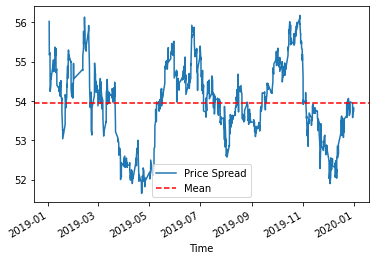

In [28]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [29]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

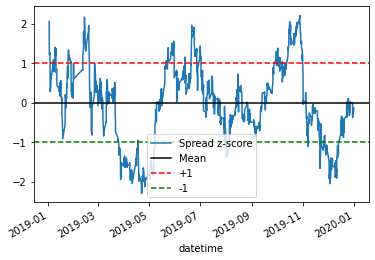

In [30]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])

## using spread

In [36]:
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm


def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[('VN30F1M', 'TCB'), ('STB', 'PDR'), ('TCB', 'PDR'), ('VPB', 'NVL'), ('VRE', 'PLX'), ('VRE', 'BVH'), ('HDB', 'PDR'), ('HDB', 'PLX'), ('HDB', 'KDH'), ('HDB', 'NVL'), ('HDB', 'MWG'), ('HDB', 'VIC'), ('PDR', 'TPB'), ('BID', 'BVH'), ('BID', 'MWG'), ('BID', 'VCB')]


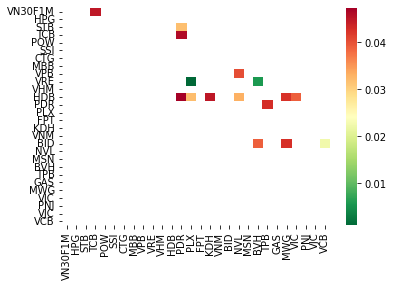

In [34]:
df.dropna(inplace=True)

# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbols, yticklabels=symbols, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [35]:
S1 = df['VN30F1M']
S2 = df['TCB']

score, pvalue, _ = coint(S1, S2)
pvalue

0.04490833901620356

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


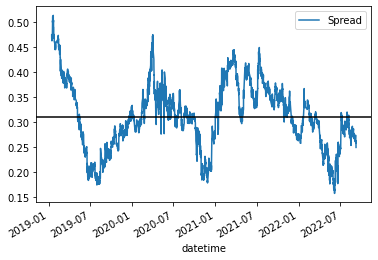

In [39]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['VN30F1M']
b = results.params['VN30F1M']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

In [40]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


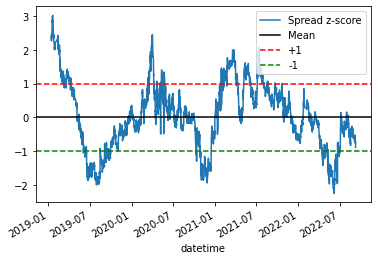

In [41]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])